#### TODO: 

#### Normalise by 


#### Other motif residues 
- create 2nd and 3rd place combinations
to get a better idea of the motif.  


i.e. 
get "top 3" closest apart from sequence-adjacent residues, considering
a. RRA the same as RAR and ARR 
b. RR- (if only 2 within bubble)

Also, 

#### Weighted score
- somehow 'weight' the distance to the contribution 
- i.e. sometimes the 3rd closest residue will be very close; othertimes it will be just on the edge of the bubble and we need to account for this


NOTE: this is likely not to matter too much (or vary a lot) since we are already controlling for distance by enforcing the bubble radius in the first place. 

What is likely to vary, however, is if we weight by RSA (i.e. higher surface accessibility contributions should matter more) as the residue is likely more visible and important to the kinase. 





## Visualising motifs

In [4]:
# Autoreload 
%load_ext autoreload
%autoreload 2

from pathlib import Path 
import pandas as pd 
import numpy as np
import os 
import re 
import gzip 
import shutil
import Bio.PDB.MMCIF2Dict
from typing import Union, List, Tuple, Dict, Optional
from pathlib import Path

pd.options.mode.chained_assignment = None  # default='warn'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# LOAD DATAFRAMES
# For each file that ends with .csv, load it into a dataframe.
radius = 6.0
motif_dfs = []
for f in Path("data/processed/motifs").glob(f"*-R{radius}Å.csv"):
    try:
        df = pd.read_csv(
            f, 
            header=0,
            delimiter="\t",
        )
    except pd.errors.EmptyDataError:
        continue
    motif_dfs.append(df)

In [6]:
motif_df = pd.concat(motif_dfs)
motif_df

,uniprot_id,prev,site,next,nearest_node
0,A0A0B4J2A2,A:LYS:118,A:THR:119,A:GLU:120,A:HIS:92
1,A0A0B4J2A2,A:GLY:109,A:SER:110,A:GLN:111,A:LYS:76
2,A0A0B4J2A2,A:LEU:98,A:SER:99,A:MET:100,A:ALA:128
3,A0A0B4J2A2,A:GLY:94,A:SER:95,A:GLY:96,A:THR:116
4,A0A0B4J2A2,A:ILE:78,A:TYR:79,A:GLY:80,A:SER:77
...,...,...,...,...,...
0,Q96GZ6,A:GLN:274,A:SER:275,A:PRO:276,A:ILE:278
1,Q96GZ6,A:SER:27,A:THR:28,A:GLY:29,NaN
2,Q96GZ6,A:LEU:26,A:SER:27,A:THR:28,NaN
3,Q96GZ6,A:VAL:48,A:THR:49,A:PRO:50,A:SER:47


In [7]:
motif_df["site_res"] = motif_df.apply(
    lambda row: row["site"].split(":")[1], 
    axis=1,
)

In [8]:
nearest_node = motif_df[~motif_df["nearest_node"].isna()]
nearest_node

,uniprot_id,prev,site,next,nearest_node,site_res
0,A0A0B4J2A2,A:LYS:118,A:THR:119,A:GLU:120,A:HIS:92,THR
1,A0A0B4J2A2,A:GLY:109,A:SER:110,A:GLN:111,A:LYS:76,SER
2,A0A0B4J2A2,A:LEU:98,A:SER:99,A:MET:100,A:ALA:128,SER
3,A0A0B4J2A2,A:GLY:94,A:SER:95,A:GLY:96,A:THR:116,SER
4,A0A0B4J2A2,A:ILE:78,A:TYR:79,A:GLY:80,A:SER:77,TYR
...,...,...,...,...,...,...
9,Q9UK17,A:ARG:107,A:TYR:108,A:GLU:109,A:PRO:106,TYR
10,Q9UK17,A:GLU:135,A:TYR:136,A:LYS:137,A:TYR:133,TYR
0,Q96GZ6,A:GLN:274,A:SER:275,A:PRO:276,A:ILE:278,SER
3,Q96GZ6,A:VAL:48,A:THR:49,A:PRO:50,A:SER:47,THR


In [9]:
list(nearest_node["uniprot_id"].unique())[0:2]

['A0A0B4J2A2', 'Q8IVU1']

In [10]:
def seq_distance(
    node_id1: str, 
    node_id2: str,
) -> int: 
    """Return difference in sequence position between two nodes."""
    pos1 = int(node_id1.split(":")[-1])
    pos2 = int(node_id2.split(":")[-1])
    return pos1 - pos2

In [11]:
nearest_node["sequence_distance"] = nearest_node.apply(
    lambda row: seq_distance(row["site"], row["nearest_node"]),
    axis=1,
)
nearest_node

,uniprot_id,prev,site,next,nearest_node,site_res,sequence_distance
0,A0A0B4J2A2,A:LYS:118,A:THR:119,A:GLU:120,A:HIS:92,THR,27
1,A0A0B4J2A2,A:GLY:109,A:SER:110,A:GLN:111,A:LYS:76,SER,34
2,A0A0B4J2A2,A:LEU:98,A:SER:99,A:MET:100,A:ALA:128,SER,-29
3,A0A0B4J2A2,A:GLY:94,A:SER:95,A:GLY:96,A:THR:116,SER,-21
4,A0A0B4J2A2,A:ILE:78,A:TYR:79,A:GLY:80,A:SER:77,TYR,2
...,...,...,...,...,...,...,...
9,Q9UK17,A:ARG:107,A:TYR:108,A:GLU:109,A:PRO:106,TYR,2
10,Q9UK17,A:GLU:135,A:TYR:136,A:LYS:137,A:TYR:133,TYR,3
0,Q96GZ6,A:GLN:274,A:SER:275,A:PRO:276,A:ILE:278,SER,-3
3,Q96GZ6,A:VAL:48,A:THR:49,A:PRO:50,A:SER:47,THR,2


In [12]:
# min and max sequence distance
print(nearest_node["sequence_distance"].min())
print(nearest_node["sequence_distance"].max())

-2409
2381


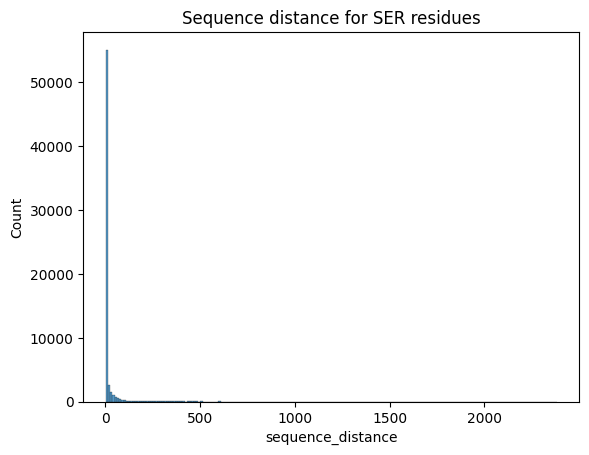

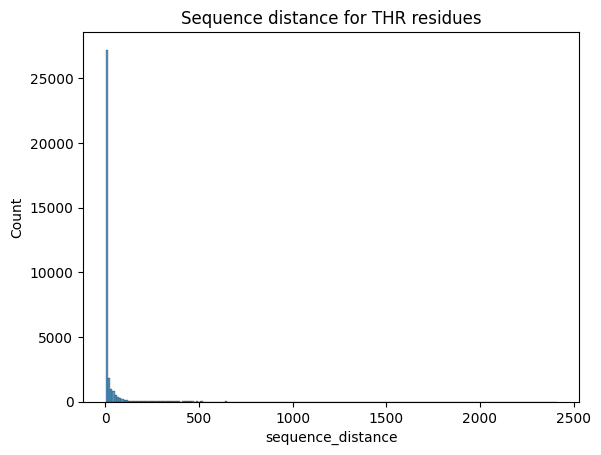

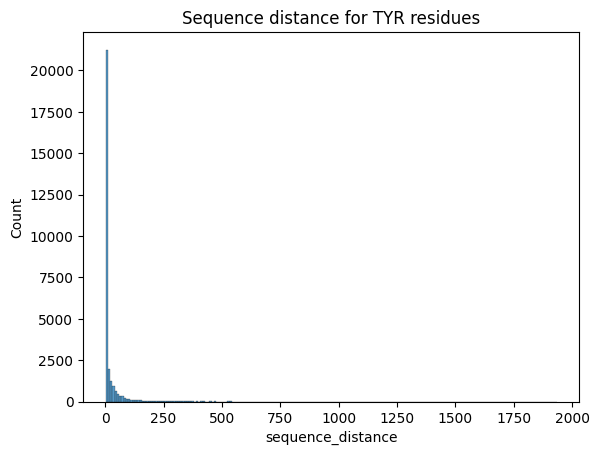

In [13]:
# plot histogram of sequence distances
import matplotlib.pyplot as plt
import seaborn as sns

absolute_val = True
for aa in ["SER", "THR", "TYR"]:
    df = nearest_node[nearest_node["site_res"] == aa]
    if absolute_val:
        df["sequence_distance"] = df["sequence_distance"].abs()
    # plot histogram of sequence distances per residue 
    plt.figure()
    sns.histplot(
        data=df,
        x="sequence_distance",
        bins=200,
    )
    plt.title(f"Sequence distance for {aa} residues")
    plt.show()


In [14]:
def filter_df_residue(
    df: pd.DataFrame,
    residue: str,
    
) -> pd.DataFrame:
    """Filter dataframe to only include rows with the specified residue."""
    df = df[df["site_res"] == residue]
    df["prev"] = df["prev"].apply(lambda x: x.split(":")[1])

    def func(x):
        if isinstance(x, float):
            return np.nan
        return x.split(":")[1]
    df["next"] = df["next"].apply(lambda x: func(x))
    return df

In [15]:
serine      = filter_df_residue(nearest_node, "SER")
threonine   = filter_df_residue(nearest_node, "THR")
tyrosine    = filter_df_residue(nearest_node, "TYR")
len(serine), len(threonine), len(tyrosine)

(64551, 33350, 28859)

In [16]:
serine[0:2]

,uniprot_id,prev,site,next,nearest_node,site_res,sequence_distance
1,A0A0B4J2A2,GLY,A:SER:110,GLN,A:LYS:76,SER,34
2,A0A0B4J2A2,LEU,A:SER:99,MET,A:ALA:128,SER,-29


In [17]:
# Group by every combination of prev and next; 
# Count the number of times each combination occurs.
serine.groupby(["prev", "next"]).size().reset_index(name="count")

,prev,next,count
0,ALA,ALA,329
1,ALA,ARG,251
2,ALA,ASN,119
3,ALA,ASP,200
4,ALA,CYS,63
...,...,...,...
395,VAL,SER,299
396,VAL,THR,152
397,VAL,TRP,39
398,VAL,TYR,89


In [18]:
serine["nearest_res"] = serine["nearest_node"].apply(lambda x: x.split(":")[1])
# For each combination of (prev, next); count the number of times each nearest_res occurs. 
motif_counts = serine.groupby(["prev", "next", "nearest_res"]).size().reset_index(name="count")
# Collapse to one row per combination of (prev, next), and a column for each nearest_res.  
motif_counts = motif_counts.pivot_table(
    index=["prev", "next"],
    columns="nearest_res",
    values="count",
    fill_value=0,
).reset_index()
motif_counts


nearest_res,prev,next,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,...,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL
0,ALA,ALA,45,33,10,14,4,22,34,14,...,31,21,10,8,8,23,15,5,6,7
1,ALA,ARG,30,23,5,14,10,14,17,24,...,20,15,6,9,6,19,9,0,7,6
2,ALA,ASN,6,9,5,9,0,3,11,9,...,12,14,0,4,4,8,6,0,5,5
3,ALA,ASP,15,14,7,15,3,4,18,10,...,22,14,3,4,8,21,14,1,4,7
4,ALA,CYS,1,2,5,2,2,2,6,5,...,11,2,1,3,2,3,4,0,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,VAL,SER,22,22,10,19,3,21,16,19,...,28,19,7,13,8,37,13,1,7,15
396,VAL,THR,16,13,3,7,6,8,9,9,...,10,8,4,3,4,20,11,1,1,3
397,VAL,TRP,2,1,2,1,2,4,2,1,...,4,2,0,1,1,5,3,3,1,1
398,VAL,TYR,5,5,5,5,2,2,6,0,...,15,4,2,0,2,9,5,2,1,13


In [19]:
# Make the prev and next columns into a single column and use as the index.
motif_counts["motif"] = motif_counts.apply(
    lambda row: f"{row['prev']}-{row['next']}",
    axis=1,
)
motif_counts = motif_counts.set_index("motif")

# Drop the prev and next columns.
motif_counts = motif_counts.drop(columns=["prev", "next"])
motif_counts

nearest_res,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL
motif,,,,,,,,,,,,,,,,,,,,
ALA-ALA,45,33,10,14,4,22,34,14,9,10,31,21,10,8,8,23,15,5,6,7
ALA-ARG,30,23,5,14,10,14,17,24,5,12,20,15,6,9,6,19,9,0,7,6
ALA-ASN,6,9,5,9,0,3,11,9,3,6,12,14,0,4,4,8,6,0,5,5
ALA-ASP,15,14,7,15,3,4,18,10,6,10,22,14,3,4,8,21,14,1,4,7
ALA-CYS,1,2,5,2,2,2,6,5,1,1,11,2,1,3,2,3,4,0,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VAL-SER,22,22,10,19,3,21,16,19,5,14,28,19,7,13,8,37,13,1,7,15
VAL-THR,16,13,3,7,6,8,9,9,8,8,10,8,4,3,4,20,11,1,1,3
VAL-TRP,2,1,2,1,2,4,2,1,1,2,4,2,0,1,1,5,3,3,1,1


In [20]:
# Group by every combination of prev and next; 
# Count the number of times each combination occurs.
count_df = serine.groupby(["prev", "next"]).size().reset_index(name="count")

# Turn into a 2d matrix where each row is a prev and each column is a next.
count_df = count_df.pivot_table(
    index="prev",
    columns="next",
    values="count",
    fill_value=0,
)

In [21]:
def make_count_df(
    df: pd.DataFrame,
):
    count_df = df.groupby(["prev", "next"]).size().reset_index(name="count")

    # Turn into a 2d matrix where each row is a prev and each column is a next.
    count_df = count_df.pivot_table(
        index="prev",
        columns="next",
        values="count",
        fill_value=0,
    )
    return count_df

def make_motif_df(
    df: pd.DataFrame
) -> pd.DataFrame:
    df["nearest_res"] = df["nearest_node"].apply(lambda x: x.split(":")[1])
    # For each combination of (prev, next); count the number of times each nearest_res occurs. 
    motif_counts = df.groupby(["prev", "next", "nearest_res"]).size().reset_index(name="count")
    # Collapse to one row per combination of (prev, next), and a column for each nearest_res.  
    motif_counts = motif_counts.pivot_table(
        index=["prev", "next"],
        columns="nearest_res",
        values="count",
        fill_value=0,
    ).reset_index()
    motif_counts
    # Make the prev and next columns into a single column and use as the index.
    motif_counts["motif"] = motif_counts.apply(
        lambda row: f"{row['prev']}-{row['next']}",
        axis=1,
    )
    motif_counts = motif_counts.set_index("motif")

    # Drop the prev and next columns.
    motif_counts = motif_counts.drop(columns=["prev", "next"])
    return motif_counts

In [22]:
# Visualise as heatmap.
import plotly.express as px

def plot_heatmap(
    df: pd.DataFrame,
    aspect: str = None,
    title: str = f"Motif counts for nearest residues (R={radius}Å)",
    colour: str = "viridis",
):
    fig = px.imshow(
        df.T,
        color_continuous_scale=colour,
        # Don't enforce square 
        #width=1600,
        height=1000,
        #labels=label_dict,
        title=title,
        aspect=aspect,
        
    )
    fig.update_xaxes(
        type='category', # In case we are using CIDs (integers)
        tickangle=45,
    ) 
    fig.update_yaxes(type='category')
    fig.show()

In [23]:
dff = motif_counts.div(motif_counts.sum().sum())
plot_heatmap(dff, aspect="auto")

dff = motif_counts.div(motif_counts.sum(axis=1), axis=0)
plot_heatmap(dff, aspect="auto")





In [24]:
motif_df

,uniprot_id,prev,site,next,nearest_node,site_res
0,A0A0B4J2A2,A:LYS:118,A:THR:119,A:GLU:120,A:HIS:92,THR
1,A0A0B4J2A2,A:GLY:109,A:SER:110,A:GLN:111,A:LYS:76,SER
2,A0A0B4J2A2,A:LEU:98,A:SER:99,A:MET:100,A:ALA:128,SER
3,A0A0B4J2A2,A:GLY:94,A:SER:95,A:GLY:96,A:THR:116,SER
4,A0A0B4J2A2,A:ILE:78,A:TYR:79,A:GLY:80,A:SER:77,TYR
...,...,...,...,...,...,...
0,Q96GZ6,A:GLN:274,A:SER:275,A:PRO:276,A:ILE:278,SER
1,Q96GZ6,A:SER:27,A:THR:28,A:GLY:29,NaN,THR
2,Q96GZ6,A:LEU:26,A:SER:27,A:THR:28,NaN,SER
3,Q96GZ6,A:VAL:48,A:THR:49,A:PRO:50,A:SER:47,THR


In [25]:
def get_top_hit_df(motif_df: pd.DataFrame) -> pd.DataFrame:
    """Return a dataframe with the top hit for each motif."""
    # New column "res" which stores the column name of the largest value in each row.
    df = pd.DataFrame()
    df.index = motif_df.index
    df["res"] = motif_df.idxmax(axis=1)
    
    # New column "count" which stores the largest value in each row.
    df["count"] = motif_df.max(axis=1)
    return df

def make_adjacency_matrix(
    motif_df: pd.DataFrame,
    column: str = "count",
) -> pd.DataFrame:
    """Turn df into an adjacency matrix.
    
    Assumes index is of form "A-B"
    """
    # Split the index into prev and next columns.
    motif_df["prev"] = motif_df.index.str.split("-").str[0]
    motif_df["next"] = motif_df.index.str.split("-").str[1]
    # Turn into a 2d matrix where each row is a prev and each column is a next.


    # Check if column is numeric. 
    if motif_df[column].dtype == "object":

        #raise ValueError(f"Column {column} is not numeric.")
        
        # Make a dictionary of the unique values in the column.
        unique_values = motif_df[column].unique()
        value_dict = {value: i for i, value in enumerate(unique_values)}
        # Replace the values in the column with the index of the value in the dictionary.
        motif_df[column] = motif_df[column].apply(lambda x: value_dict[x])
        df = motif_df.pivot_table(
            index="prev",
            columns="next",
            values=column,
            fill_value=0,
        )
        
        # Convert back to the original values.
        df = df.applymap(lambda x: unique_values[x])
        return df
    else:
        df = motif_df.pivot_table(
            index="prev",
            columns="next",
            values=column,
            fill_value=0,
        )
        return df


In [26]:
normalisation = "sum"
for site in ["SER", "THR", "TYR"]:
    df = filter_df_residue(nearest_node, site)
    count_df = make_count_df(df)
    motif_df = make_motif_df(df)
    
    plot_heatmap(count_df, title=f"{site} phosphosites: frequency of sequence-adjacent residue pairs (R={radius}Å)", aspect=None)

    dff = motif_df / motif_df.sum().sum()
    # TODO: normalise properly with AA frequency

    # plot_heatmap(dff, title=f"{site} phosphosites: frequency of next-nearest residue (R={radius}Å)", aspect="auto") 

    if False: 
        # Get "top hit" i.e. the residue that occurs most frequently for each combination of prev and next. 
        dff = make_adjacency_matrix(get_top_hit_df(motif_df), column="res")
        # Turn values in dff into integers to represent each unique residue.
        residues = dff.values.flatten() 
        unique_residues = np.unique(residues)
        residue_dict = {residue: i for i, residue in enumerate(unique_residues)}
        dff = dff.applymap(lambda x: residue_dict[x])
        plot_heatmap(dff, title=f"{site} phosphosites: most common next-nearest residue (R={radius}Å)", aspect="auto", colour="PiYG") 


### Plot normalised heatmaps.

In [29]:
df = filter_df_residue(nearest_node, "SER")
count_df = make_count_df(df)
count_df

next,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL
prev,,,,,,,,,,,,,,,,,,,,
ALA,329,251,119,200,63,286,296,290,67,169,608,234,94,199,516,291,153,46,87,277
ARG,243,300,121,160,62,216,193,219,86,220,631,147,116,194,454,328,145,50,80,251
ASN,134,108,77,123,47,125,158,112,61,189,350,133,67,96,265,187,108,35,68,140
ASP,217,144,118,396,51,173,357,271,43,184,468,141,69,167,353,262,118,40,97,213
CYS,51,54,18,52,34,50,111,59,21,35,100,50,18,43,123,86,55,17,16,70
GLN,135,136,64,86,38,157,107,126,45,137,401,137,59,116,301,197,71,28,51,145
GLU,193,180,68,257,58,202,381,221,52,168,512,149,88,162,372,243,132,42,83,215
GLY,231,230,98,234,103,246,234,357,74,204,560,215,87,180,536,267,149,58,101,285
HIS,85,91,42,98,14,85,76,247,29,81,233,78,37,85,197,122,62,25,37,100


In [35]:
# Normalise to frequencies.
count_df = count_df.div(count_df.sum().sum())

In [46]:
from phosphosite.utils.compseq import parse_compseq_output
df = parse_compseq_output()
df.loc["freq", "ASA"]

0.0004622

In [50]:
from phosphosite.utils.normalisation import get_frequency_matrix 
fdf = get_frequency_matrix(centre_residue="S", metric="freq")
fdf

,A,C,D,E,F,G,H,I,K,L,...,P,Q,R,S,T,U,V,W,Y,h
A,0.0001,0.000036,0.000087,0.000089,0.000063,0.000107,0.000044,0.000079,0.000072,0.000158,...,0.000073,0.000068,0.000092,0.000126,0.000081,0.0,0.000097,0.000019,0.000051,NaN
C,0.000031,0.000019,0.000031,0.000036,0.000027,0.000039,0.000017,0.000029,0.000029,0.000061,...,0.000027,0.000027,0.000039,0.000067,0.000033,0.0,0.000038,0.000008,0.000022,NaN
D,0.000071,0.000032,0.000083,0.000118,0.000069,0.000082,0.000036,0.000091,0.000071,0.000139,...,0.000055,0.000051,0.000079,0.000109,0.000062,0.0,0.000093,0.000019,0.000064,NaN
E,0.000079,0.00004,0.00007,0.00012,0.000076,0.000079,0.000035,0.000086,0.000093,0.000189,...,0.000058,0.000081,0.000078,0.000105,0.000074,0.0,0.000097,0.00002,0.000052,NaN
F,0.000066,0.000032,0.000055,0.000072,0.000057,0.000084,0.000038,0.000063,0.000066,0.000111,...,0.000058,0.00006,0.000072,0.000101,0.000082,0.0,0.00007,0.000015,0.000041,NaN
G,0.000086,0.000045,0.000078,0.000086,0.000076,0.000154,0.000045,0.000087,0.000075,0.00016,...,0.000105,0.000077,0.00011,0.000142,0.0001,0.0,0.000103,0.000025,0.000064,NaN
H,0.000047,0.000021,0.000039,0.000046,0.000041,0.000047,0.000023,0.00004,0.00004,0.000082,...,0.000041,0.000038,0.000052,0.000061,0.000046,0.0,0.000043,0.000016,0.00003,NaN
I,0.000072,0.000035,0.000074,0.000087,0.000067,0.000086,0.000043,0.000064,0.000082,0.000119,...,0.000062,0.000068,0.000073,0.000127,0.000091,0.0,0.000077,0.00002,0.000044,NaN
K,0.000071,0.000037,0.000067,0.0001,0.000076,0.000101,0.00004,0.000089,0.000108,0.00016,...,0.000075,0.000075,0.000086,0.000115,0.000068,0.0,0.000082,0.000023,0.000054,NaN
L,0.000147,0.000063,0.00012,0.000165,0.000109,0.000162,0.000082,0.000105,0.000154,0.000255,...,0.000133,0.000127,0.000176,0.000205,0.000138,0.0,0.00014,0.000039,0.000086,NaN


In [ ]:
normalisation = "sum"
for site in ["SER", "THR", "TYR"]:
    df = filter_df_residue(nearest_node, site)
    count_df = make_count_df(df)
    motif_df = make_motif_df(df)
    
    plot_heatmap(count_df, title=f"{site} phosphosites: frequency of sequence-adjacent residue pairs (R={radius}Å)", aspect=None)

    dff = motif_df / motif_df.sum().sum()
    # TODO: normalise properly with AA frequency